In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

## 1) Подготовка данных и предварительный анализ

In [50]:
df = pd.read_csv("csgo_games.csv")

# почти 4к строк и 170 столбцов
df.shape

(3787, 170)

In [51]:
df.head(10)

,match_date,team_1,team_2,t1_points,t2_points,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,t1_player1_apr,t1_player1_dpr,t1_player1_spr,t1_player1_opk_ratio,t1_player1_opk_rating,t1_player1_wins_perc_after_fk,t1_player1_fk_perc_in_wins,t1_player1_multikill_perc,t1_player1_rating_at_least_one_perc,t1_player1_is_sniper,t1_player1_clutch_win_perc,t1_player2_rating,t1_player2_impact,t1_player2_kdr,t1_player2_dmr,t1_player2_kpr,t1_player2_apr,t1_player2_dpr,t1_player2_spr,t1_player2_opk_ratio,t1_player2_opk_rating,t1_player2_wins_perc_after_fk,t1_player2_fk_perc_in_wins,t1_player2_multikill_perc,t1_player2_rating_at_least_one_perc,...,t2_player3_opk_ratio,t2_player3_opk_rating,t2_player3_wins_perc_after_fk,t2_player3_fk_perc_in_wins,t2_player3_multikill_perc,t2_player3_rating_at_least_one_perc,t2_player3_is_sniper,t2_player3_clutch_win_perc,t2_player4_rating,t2_player4_impact,t2_player4_kdr,t2_player4_dmr,t2_player4_kpr,t2_player4_apr,t2_player4_dpr,t2_player4_spr,t2_player4_opk_ratio,t2_player4_opk_rating,t2_player4_wins_perc_after_fk,t2_player4_fk_perc_in_wins,t2_player4_multikill_perc,t2_player4_rating_at_least_one_perc,t2_player4_is_sniper,t2_player4_clutch_win_perc,t2_player5_rating,t2_player5_impact,t2_player5_kdr,t2_player5_dmr,t2_player5_kpr,t2_player5_apr,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc
0,2016-12-18,CLOUD9,HELLRAISERS,13,16,9,20,0.500000,0.500000,t2,1.24,1.29,1.24,87.0,0.83,0.14,0.67,0.12,1.12,1.03,0.765,0.142,0.222018,0.783,False,0.705882,1.15,1.26,1.06,83.3,0.73,0.17,0.69,0.08,0.88,1.09,0.753,0.185,0.189908,0.711,...,1.34,1.13,0.737,0.178,0.161581,0.604,True,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,False,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667
1,2016-12-18,IMMORTALS,G2,17,19,13,10,0.500000,0.500000,t2,1.21,1.24,1.35,78.7,0.78,0.11,0.58,0.10,1.67,1.17,0.780,0.181,0.193422,0.776,True,0.575000,1.20,1.35,1.14,89.3,0.81,0.16,0.71,0.09,1.10,1.18,0.737,0.201,0.209622,0.776,...,1.00,1.02,0.716,0.153,0.165559,0.529,False,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,False,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
2,2016-12-18,MOUSESPORTS,IMMORTALS,16,3,12,13,0.500000,0.500000,t1,1.18,1.42,1.13,83.8,0.78,0.12,0.69,0.08,1.13,1.27,0.700,0.236,0.213103,0.745,False,0.521739,1.12,1.21,1.10,76.6,0.74,0.09,0.67,0.09,1.44,1.24,0.785,0.228,0.181081,0.625,...,1.36,0.99,0.799,0.127,0.179676,0.697,False,0.583333,1.07,1.00,1.07,73.6,0.68,0.14,0.64,0.09,1.04,0.97,0.815,0.130,0.159035,0.623,False,0.500000,1.03,1.00,0.97,74.9,0.65,0.16,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,False,0.733333
3,2016-12-18,DIGNITAS,G2,16,9,6,10,0.416667,0.583333,t1,1.19,1.17,1.24,84.1,0.77,0.13,0.62,0.10,1.14,1.02,0.743,0.134,0.200414,0.774,False,0.657143,1.18,1.26,1.15,85.5,0.78,0.14,0.68,0.10,1.16,1.11,0.793,0.179,0.199921,0.765,...,1.00,1.02,0.716,0.153,0.165559,0.529,False,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,False,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,True,0.406250
4,2016-12-18,OPTIC,HELLRAISERS,16,10,4,20,0.500000,0.500000,t1,1.19,1.21,1.19,81.4,0.78,0.14,0.65,0.12,1.13,1.06,0.754,0.155,0.196871,0.756,True,0.724138,1.14,1.20,1.08,77.1,0.72,0.14,0.67,0.11,1.22,1.14,0.743,0.179,0.177749,0.644,...,1.34,1.13,0.737,0.178,0.161581,0.604,True,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,False,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,False,0.666667
5,2016-12-17,FAZE,IMMORTALS,1

Краткое описание датасета:

### **Основная информация о матче**  
- **match_date** – дата проведения матча.  
- **team_1**, **team_2** – названия команд.  
- **t1_points**, **t2_points** – количество очков (раундов), набранных каждой командой.  
- **t1_world_rank**, **t2_world_rank** – мировой рейтинг команд.  
- **t1_h2h_win_perc**, **t2_h2h_win_perc** – процент побед команды в предыдущих встречах (head-to-head).  
- **winner** – победитель матча (team_1 или team_2).  

### **Статистика игроков команды 1 (team_1)**  
Для каждого игрока (player1, player2, ..., player5) указаны:  
- **rating** – общий рейтинг игрока (HLTV Rating или аналогичный).  
- **impact** – влияние на игру (показатель агрессивности и ключевых действий).  
- **kdr** (Kill-Death Ratio) – отношение убийств к смертям.  
- **dmr** (Damage per Round) – средний урон за раунд.  
- **kpr** (Kills per Round) – убийств за раунд.  
- **apr** (Assists per Round) – помощь в убийстве за раунд.  
- **dpr** (Deaths per Round) – смертей за раунд.  
- **spr** (Survival per Round) – процент выживаний в раундах.  
- **opk_ratio** (Opening Kill Ratio) – эффективность в первых убийствах.  
- **opk_rating** – рейтинг первых убийств.  
- **wins_perc_after_fk** – процент выигранных раундов после первого убийства.  
- **fk_perc_in_wins** – доля первых убийств в победах.  
- **multikill_perc** – процент раундов с мультиубийствами (2+ убийства).  
- **rating_at_least_one_perc** – процент раундов с рейтингом ≥ 1.0.  
- **is_sniper** – является ли игрок снайпером (1/0).  
- **clutch_win_perc** – процент выигранных клатчей (1vsX).  

### **Статистика игроков команды 2 (team_2)**  
Аналогичные показатели для каждого игрока второй команды (player1, player2, ..., player5).  

### **Общий вывод**  
Датасет содержит:  
- Общую информацию о матче (дата, команды, счет, рейтинги).  
- Подробную статистику по каждому игроку (5 игроков в каждой команде).  
- Показатели эффективности, влияния, клатчей, открывающих убийств и другие ключевые метрики.

In [52]:
# Чекаю где именно есть пропуски, т.к. df.info не хочет выдавать инфу на 170 колонок

l = df.isna().sum()

for i in range(len(l)):
    if l.values[i] > 0:
        print(l.keys()[i], " - ", l.values[i])

t1_player5_wins_perc_after_fk  -  2
t2_player3_wins_perc_after_fk  -  1
t2_player5_wins_perc_after_fk  -  1


In [53]:
# пропусков 0.079% потому от их удаления ничего плохого не случится

df.dropna(inplace=True)
df.isna().sum().sum()

np.int64(0)

In [54]:
df.drop_duplicates(inplace=True)
df.shape

# 3787 - 3 = 3784, значит был один какой-то дубликат

(3783, 170)

In [55]:
bool_columns = df.columns[df.dtypes == bool].tolist()
bool_columns

['t1_player1_is_sniper',
 't1_player2_is_sniper',
 't1_player3_is_sniper',
 't1_player4_is_sniper',
 't1_player5_is_sniper',
 't2_player1_is_sniper',
 't2_player2_is_sniper',
 't2_player3_is_sniper',
 't2_player4_is_sniper',
 't2_player5_is_sniper']

In [56]:
for col in bool_columns:
    df[col] = df[col].apply(lambda x: int(x == True))

df

,match_date,team_1,team_2,t1_points,t2_points,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,t1_player1_apr,t1_player1_dpr,t1_player1_spr,t1_player1_opk_ratio,t1_player1_opk_rating,t1_player1_wins_perc_after_fk,t1_player1_fk_perc_in_wins,t1_player1_multikill_perc,t1_player1_rating_at_least_one_perc,t1_player1_is_sniper,t1_player1_clutch_win_perc,t1_player2_rating,t1_player2_impact,t1_player2_kdr,t1_player2_dmr,t1_player2_kpr,t1_player2_apr,t1_player2_dpr,t1_player2_spr,t1_player2_opk_ratio,t1_player2_opk_rating,t1_player2_wins_perc_after_fk,t1_player2_fk_perc_in_wins,t1_player2_multikill_perc,t1_player2_rating_at_least_one_perc,...,t2_player3_opk_ratio,t2_player3_opk_rating,t2_player3_wins_perc_after_fk,t2_player3_fk_perc_in_wins,t2_player3_multikill_perc,t2_player3_rating_at_least_one_perc,t2_player3_is_sniper,t2_player3_clutch_win_perc,t2_player4_rating,t2_player4_impact,t2_player4_kdr,t2_player4_dmr,t2_player4_kpr,t2_player4_apr,t2_player4_dpr,t2_player4_spr,t2_player4_opk_ratio,t2_player4_opk_rating,t2_player4_wins_perc_after_fk,t2_player4_fk_perc_in_wins,t2_player4_multikill_perc,t2_player4_rating_at_least_one_perc,t2_player4_is_sniper,t2_player4_clutch_win_perc,t2_player5_rating,t2_player5_impact,t2_player5_kdr,t2_player5_dmr,t2_player5_kpr,t2_player5_apr,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc
0,2016-12-18,CLOUD9,HELLRAISERS,13,16,9,20,0.500000,0.500000,t2,1.24,1.29,1.24,87.0,0.83,0.14,0.67,0.12,1.12,1.03,0.765,0.142,0.222018,0.783,0,0.705882,1.15,1.26,1.06,83.3,0.73,0.17,0.69,0.08,0.88,1.09,0.753,0.185,0.189908,0.711,...,1.34,1.13,0.737,0.178,0.161581,0.604,1,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,0,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,0,0.666667
1,2016-12-18,IMMORTALS,G2,17,19,13,10,0.500000,0.500000,t2,1.21,1.24,1.35,78.7,0.78,0.11,0.58,0.10,1.67,1.17,0.780,0.181,0.193422,0.776,1,0.575000,1.20,1.35,1.14,89.3,0.81,0.16,0.71,0.09,1.10,1.18,0.737,0.201,0.209622,0.776,...,1.00,1.02,0.716,0.153,0.165559,0.529,0,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,0,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,1,0.406250
2,2016-12-18,MOUSESPORTS,IMMORTALS,16,3,12,13,0.500000,0.500000,t1,1.18,1.42,1.13,83.8,0.78,0.12,0.69,0.08,1.13,1.27,0.700,0.236,0.213103,0.745,0,0.521739,1.12,1.21,1.10,76.6,0.74,0.09,0.67,0.09,1.44,1.24,0.785,0.228,0.181081,0.625,...,1.36,0.99,0.799,0.127,0.179676,0.697,0,0.583333,1.07,1.00,1.07,73.6,0.68,0.14,0.64,0.09,1.04,0.97,0.815,0.130,0.159035,0.623,0,0.500000,1.03,1.00,0.97,74.9,0.65,0.16,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,0,0.733333
3,2016-12-18,DIGNITAS,G2,16,9,6,10,0.416667,0.583333,t1,1.19,1.17,1.24,84.1,0.77,0.13,0.62,0.10,1.14,1.02,0.743,0.134,0.200414,0.774,0,0.657143,1.18,1.26,1.15,85.5,0.78,0.14,0.68,0.10,1.16,1.11,0.793,0.179,0.199921,0.765,...,1.00,1.02,0.716,0.153,0.165559,0.529,0,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,0,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,1,0.406250
4,2016-12-18,OPTIC,HELLRAISERS,16,10,4,20,0.500000,0.500000,t1,1.19,1.21,1.19,81.4,0.78,0.14,0.65,0.12,1.13,1.06,0.754,0.155,0.196871,0.756,1,0.724138,1.14,1.20,1.08,77.1,0.72,0.14,0.67,0.11,1.22,1.14,0.743,0.179,0.177749,0.644,...,1.34,1.13,0.737,0.178,0.161581,0.604,1,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,0,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [57]:
df["year"] = df["match_date"].apply(lambda x: int(x.split("-")[0]))
df["month"] = df["match_date"].apply(lambda x: int(x.split("-")[1]))
df["day"] = df["match_date"].apply(lambda x: int(x.split("-")[2]))
df.drop(["match_date"], axis=1, inplace=True)

df

,team_1,team_2,t1_points,t2_points,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,t1_player1_apr,t1_player1_dpr,t1_player1_spr,t1_player1_opk_ratio,t1_player1_opk_rating,t1_player1_wins_perc_after_fk,t1_player1_fk_perc_in_wins,t1_player1_multikill_perc,t1_player1_rating_at_least_one_perc,t1_player1_is_sniper,t1_player1_clutch_win_perc,t1_player2_rating,t1_player2_impact,t1_player2_kdr,t1_player2_dmr,t1_player2_kpr,t1_player2_apr,t1_player2_dpr,t1_player2_spr,t1_player2_opk_ratio,t1_player2_opk_rating,t1_player2_wins_perc_after_fk,t1_player2_fk_perc_in_wins,t1_player2_multikill_perc,t1_player2_rating_at_least_one_perc,t1_player2_is_sniper,...,t2_player3_fk_perc_in_wins,t2_player3_multikill_perc,t2_player3_rating_at_least_one_perc,t2_player3_is_sniper,t2_player3_clutch_win_perc,t2_player4_rating,t2_player4_impact,t2_player4_kdr,t2_player4_dmr,t2_player4_kpr,t2_player4_apr,t2_player4_dpr,t2_player4_spr,t2_player4_opk_ratio,t2_player4_opk_rating,t2_player4_wins_perc_after_fk,t2_player4_fk_perc_in_wins,t2_player4_multikill_perc,t2_player4_rating_at_least_one_perc,t2_player4_is_sniper,t2_player4_clutch_win_perc,t2_player5_rating,t2_player5_impact,t2_player5_kdr,t2_player5_dmr,t2_player5_kpr,t2_player5_apr,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc,year,month,day
0,CLOUD9,HELLRAISERS,13,16,9,20,0.500000,0.500000,t2,1.24,1.29,1.24,87.0,0.83,0.14,0.67,0.12,1.12,1.03,0.765,0.142,0.222018,0.783,0,0.705882,1.15,1.26,1.06,83.3,0.73,0.17,0.69,0.08,0.88,1.09,0.753,0.185,0.189908,0.711,0,...,0.178,0.161581,0.604,1,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,0,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,0,0.666667,2016,12,18
1,IMMORTALS,G2,17,19,13,10,0.500000,0.500000,t2,1.21,1.24,1.35,78.7,0.78,0.11,0.58,0.10,1.67,1.17,0.780,0.181,0.193422,0.776,1,0.575000,1.20,1.35,1.14,89.3,0.81,0.16,0.71,0.09,1.10,1.18,0.737,0.201,0.209622,0.776,0,...,0.153,0.165559,0.529,0,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,0,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,1,0.406250,2016,12,18
2,MOUSESPORTS,IMMORTALS,16,3,12,13,0.500000,0.500000,t1,1.18,1.42,1.13,83.8,0.78,0.12,0.69,0.08,1.13,1.27,0.700,0.236,0.213103,0.745,0,0.521739,1.12,1.21,1.10,76.6,0.74,0.09,0.67,0.09,1.44,1.24,0.785,0.228,0.181081,0.625,1,...,0.127,0.179676,0.697,0,0.583333,1.07,1.00,1.07,73.6,0.68,0.14,0.64,0.09,1.04,0.97,0.815,0.130,0.159035,0.623,0,0.500000,1.03,1.00,0.97,74.9,0.65,0.16,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,0,0.733333,2016,12,18
3,DIGNITAS,G2,16,9,6,10,0.416667,0.583333,t1,1.19,1.17,1.24,84.1,0.77,0.13,0.62,0.10,1.14,1.02,0.743,0.134,0.200414,0.774,0,0.657143,1.18,1.26,1.15,85.5,0.78,0.14,0.68,0.10,1.16,1.11,0.793,0.179,0.199921,0.765,0,...,0.153,0.165559,0.529,0,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,0,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,1,0.406250,2016,12,18
4,OPTIC,HELLRAISERS,16,10,4,20,0.500000,0.500000,t1,1.19,1.21,1.19,81.4,0.78,0.14,0.65,0.12,1.13,1.06,0.754,0.155,0.196871,0.756,1,0.724138,1.14,1.20,1.08,77.1,0.72,0.14,0.67,0.11,1.22,1.14,0.743,0.179,0.177749,0.644,0,...,0.178,0.161581,0.604,1,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,0,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,0,0.666667,2016,12,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [58]:
# label encoding

unik = df["team_1"].unique()
for i in range(len(unik)):
    df["team_1"].replace(unik[i], i, inplace=True)

unik = df["team_2"].unique()
for i in range(len(unik)):
    df["team_2"].replace(unik[i], i, inplace=True)

unik = df["winner"].unique()
for i in range(len(unik)):
    df["winner"].replace(unik[i], i, inplace=True)

df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16264\2480676324.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["team_1"].replace(unik[i], i, inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16264\2480676324.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["team_1"].replace(unik

,team_1,team_2,t1_points,t2_points,t1_world_rank,t2_world_rank,t1_h2h_win_perc,t2_h2h_win_perc,winner,t1_player1_rating,t1_player1_impact,t1_player1_kdr,t1_player1_dmr,t1_player1_kpr,t1_player1_apr,t1_player1_dpr,t1_player1_spr,t1_player1_opk_ratio,t1_player1_opk_rating,t1_player1_wins_perc_after_fk,t1_player1_fk_perc_in_wins,t1_player1_multikill_perc,t1_player1_rating_at_least_one_perc,t1_player1_is_sniper,t1_player1_clutch_win_perc,t1_player2_rating,t1_player2_impact,t1_player2_kdr,t1_player2_dmr,t1_player2_kpr,t1_player2_apr,t1_player2_dpr,t1_player2_spr,t1_player2_opk_ratio,t1_player2_opk_rating,t1_player2_wins_perc_after_fk,t1_player2_fk_perc_in_wins,t1_player2_multikill_perc,t1_player2_rating_at_least_one_perc,t1_player2_is_sniper,...,t2_player3_fk_perc_in_wins,t2_player3_multikill_perc,t2_player3_rating_at_least_one_perc,t2_player3_is_sniper,t2_player3_clutch_win_perc,t2_player4_rating,t2_player4_impact,t2_player4_kdr,t2_player4_dmr,t2_player4_kpr,t2_player4_apr,t2_player4_dpr,t2_player4_spr,t2_player4_opk_ratio,t2_player4_opk_rating,t2_player4_wins_perc_after_fk,t2_player4_fk_perc_in_wins,t2_player4_multikill_perc,t2_player4_rating_at_least_one_perc,t2_player4_is_sniper,t2_player4_clutch_win_perc,t2_player5_rating,t2_player5_impact,t2_player5_kdr,t2_player5_dmr,t2_player5_kpr,t2_player5_apr,t2_player5_dpr,t2_player5_spr,t2_player5_opk_ratio,t2_player5_opk_rating,t2_player5_wins_perc_after_fk,t2_player5_fk_perc_in_wins,t2_player5_multikill_perc,t2_player5_rating_at_least_one_perc,t2_player5_is_sniper,t2_player5_clutch_win_perc,year,month,day
0,0,0,13,16,9,20,0.500000,0.500000,0,1.24,1.29,1.24,87.0,0.83,0.14,0.67,0.12,1.12,1.03,0.765,0.142,0.222018,0.783,0,0.705882,1.15,1.26,1.06,83.3,0.73,0.17,0.69,0.08,0.88,1.09,0.753,0.185,0.189908,0.711,0,...,0.178,0.161581,0.604,1,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,0,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,0,0.666667,2016,12,18
1,1,1,17,19,13,10,0.500000,0.500000,0,1.21,1.24,1.35,78.7,0.78,0.11,0.58,0.10,1.67,1.17,0.780,0.181,0.193422,0.776,1,0.575000,1.20,1.35,1.14,89.3,0.81,0.16,0.71,0.09,1.10,1.18,0.737,0.201,0.209622,0.776,0,...,0.153,0.165559,0.529,0,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,0,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,1,0.406250,2016,12,18
2,2,2,16,3,12,13,0.500000,0.500000,1,1.18,1.42,1.13,83.8,0.78,0.12,0.69,0.08,1.13,1.27,0.700,0.236,0.213103,0.745,0,0.521739,1.12,1.21,1.10,76.6,0.74,0.09,0.67,0.09,1.44,1.24,0.785,0.228,0.181081,0.625,1,...,0.127,0.179676,0.697,0,0.583333,1.07,1.00,1.07,73.6,0.68,0.14,0.64,0.09,1.04,0.97,0.815,0.130,0.159035,0.623,0,0.500000,1.03,1.00,0.97,74.9,0.65,0.16,0.67,0.07,0.79,0.94,0.723,0.129,0.148257,0.526,0,0.733333,2016,12,18
3,3,1,16,9,6,10,0.416667,0.583333,1,1.19,1.17,1.24,84.1,0.77,0.13,0.62,0.10,1.14,1.02,0.743,0.134,0.200414,0.774,0,0.657143,1.18,1.26,1.15,85.5,0.78,0.14,0.68,0.10,1.16,1.11,0.793,0.179,0.199921,0.765,0,...,0.153,0.165559,0.529,0,0.500000,0.96,0.88,0.91,70.9,0.65,0.12,0.71,0.11,0.79,0.87,0.733,0.105,0.153471,0.422,0,0.347826,0.94,0.93,0.88,66.8,0.60,0.12,0.69,0.09,0.85,0.96,0.739,0.147,0.135810,0.438,1,0.406250,2016,12,18
4,4,0,16,10,4,20,0.500000,0.500000,1,1.19,1.21,1.19,81.4,0.78,0.14,0.65,0.12,1.13,1.06,0.754,0.155,0.196871,0.756,1,0.724138,1.14,1.20,1.08,77.1,0.72,0.14,0.67,0.11,1.22,1.14,0.743,0.179,0.177749,0.644,0,...,0.178,0.161581,0.604,1,0.545455,1.03,0.99,1.01,73.7,0.68,0.13,0.67,0.10,0.92,0.91,0.778,0.113,0.163662,0.528,0,0.750000,1.02,0.88,1.02,70.9,0.64,0.11,0.63,0.10,1.05,0.92,0.733,0.104,0.147018,0.528,0,0.666667,2016,12,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

#### визцализашка распределений

In [59]:
# def visualize_distributions(df, features):

#     num_features = len(features)
#     fig, axes = plt.subplots(num_features, 2, figsize=(5, num_features))
#     fig.tight_layout(pad=1.0)

#     for i, feature in enumerate(features):

#         sns.histplot(df[feature], kde=True, ax=axes[i, 0])
#         sns.boxplot(x=df[feature], ax=axes[i, 1])

#     plt.show()

In [60]:
# visualize_distributions(df, df.columns)

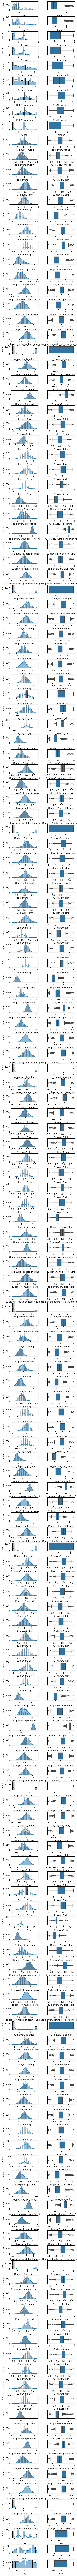

#### мне сильно впадлу скроллить этот график

<Axes: >

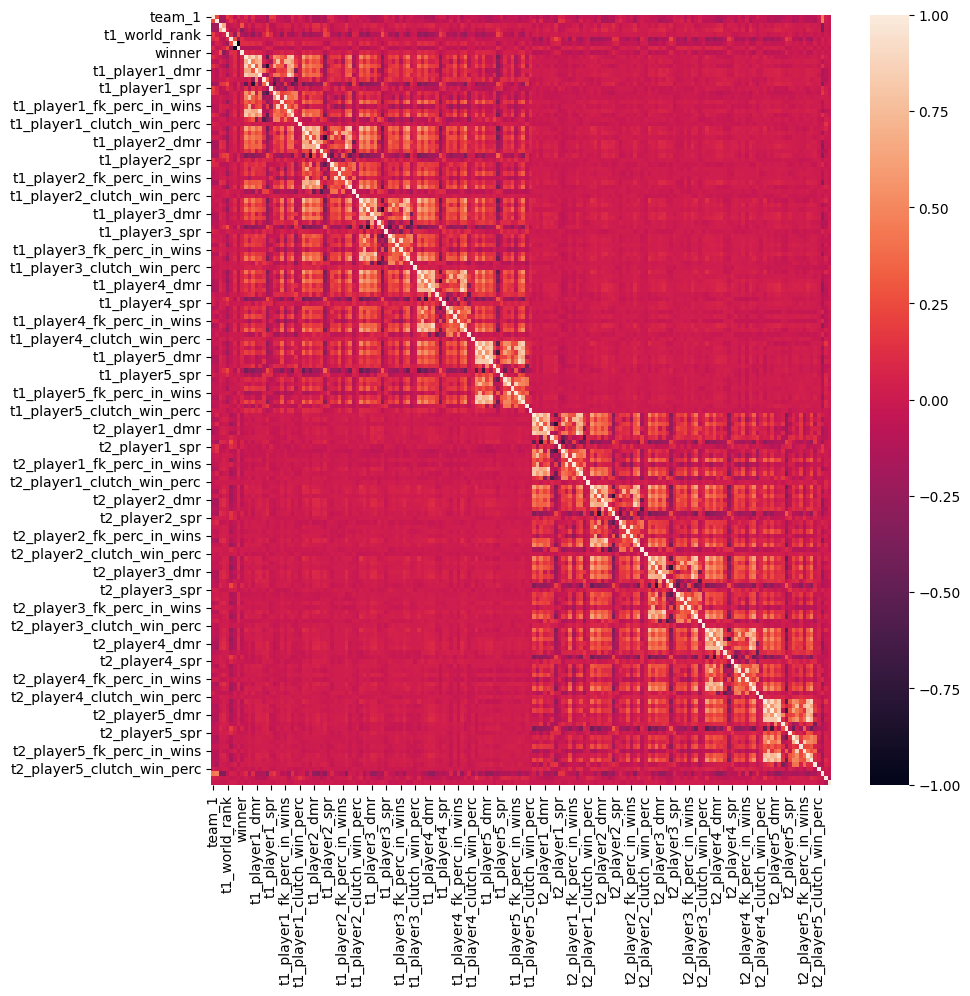

In [61]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())

In [62]:
feature = "t1_world_rank"
threshold = 0.025

corr_matrix = df.corr()
feature_correlations = corr_matrix[feature].drop(feature)
lcf = feature_correlations[abs(feature_correlations) < threshold].index.tolist()

#low correlated features
df.drop(lcf, axis=1, inplace=True)

df.shape

(3783, 107)

In [63]:
df = (df - df.mean()) / df.std()

X = df.drop([feature], axis=1).values
Y = df[feature].values

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## 2) Реализация и обучение базовой RBF-сети

In [64]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors


def initialize_centers(method, X, n_centers):
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=n_centers)
        kmeans.fit(X)
        return kmeans.cluster_centers_
    elif method == 'random':
        indices = np.random.choice(X.shape[0], n_centers, replace=False)
        return X[indices]


def calculate_sigmas(method, centers, X=None):
    if method == 'nearest':
        nbrs = NearestNeighbors(n_neighbors=2).fit(centers)
        distances, _ = nbrs.kneighbors(centers)
        return distances[:, 1] / np.sqrt(2)
    elif method == 'global':
        avg_dist = np.mean(np.linalg.norm(centers - np.mean(centers, axis=0), axis=1))
        return np.array([avg_dist / np.sqrt(2 * centers.shape[0])])


class RBFLayer(tf.keras.layers.Layer):
    def __init__(self, num_centers, kernel_type='gaussian', initial_centers=None, initial_sigmas=None, trainable_centers=False):
        super(RBFLayer, self).__init__()
        self.num_centers = num_centers
        self.kernel_type = kernel_type
        self.initial_centers = initial_centers
        self.initial_sigmas = initial_sigmas
        self.trainable_centers = trainable_centers

    def build(self, input_shape):
        # Инициализация центров
        if self.initial_centers is None:
            self.centers = self.add_weight(
                shape=(self.num_centers, input_shape[-1]),
                initializer='random_normal',
                trainable=True
            )
        else:
            self.centers = tf.Variable(
                initial_value=self.initial_centers,
                dtype=tf.float32,
                trainable=self.trainable_centers
            )

        # Инициализация ширины ядер
        if self.initial_sigmas is None:
            self.sigma = self.add_weight(
                shape=(self.num_centers,),
                initializer='ones',
                trainable=True
            )
        else:
            self.sigma = tf.Variable(
                initial_value=self.initial_sigmas,
                dtype=tf.float32,
                trainable=False
            )

    def call(self, inputs):
        # Вычисление евклидовых расстояний
        pairwise_diff = tf.expand_dims(inputs, 1) - tf.expand_dims(self.centers, 0)
        pairwise_sqdist = tf.reduce_sum(tf.square(pairwise_diff), axis=-1)

        # RBF фкнции
        if self.kernel_type == 'gaussian':
            return tf.exp(-pairwise_sqdist / (2 * tf.square(self.sigma) + 0.001))
        elif self.kernel_type == 'multiquadric':
            return tf.sqrt(1 + pairwise_sqdist / tf.square(self.sigma))
        elif self.kernel_type == 'inverse_multiquadric':
            return 1/(tf.sqrt(1 + pairwise_sqdist / tf.square(self.sigma)) + 0.001)
        else:
            raise ValueError("Unsupported kernel type")


def build_rbf_model(n_centers=10, kernel='gaussian', init_method='kmeans', sigma_method='nearest', output_learning='pseudoinverse'):
    centers = initialize_centers(init_method, X_train, n_centers)
    sigmas = calculate_sigmas(sigma_method, centers, X_train)

    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    rbf_layer = RBFLayer(
        num_centers=n_centers,
        kernel_type=kernel,
        initial_centers=centers,
        initial_sigmas=sigmas,
        trainable_centers=(init_method == 'random')
    )
    rbf_output = rbf_layer(inputs)

    if output_learning == 'pseudoinverse':
        rbf_model = tf.keras.Model(inputs, rbf_output)
        rbf_features = rbf_model.predict(X_train, verbose=0)
        
        y_train_np = np.array(y_train).reshape(-1, 1)
        weights = np.linalg.pinv(rbf_features) @ y_train_np
        
        outputs = tf.keras.layers.Dense(1, trainable=False)(rbf_output)
        model = tf.keras.Model(inputs, outputs)
        model.layers[-1].set_weights([weights, np.zeros(1)])
    else:
        outputs = tf.keras.layers.Dense(1)(rbf_output)
        model = tf.keras.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='mse')
    
    return model


In [65]:
# пупупу надо чтото написать

kernels = ["gaussian", "multiquadric", "inverse_multiquadric"]
init_methods = ["kmeans", "random"]
sigma_methods = ["nearest", "global"]
output_learnings = ["gradient", "pseudoinverse"]

configs = [
    {'kernel': k, 'init_method': im, 'sigma_method': sm, 'output_learning': om}
    for k in kernels for im in init_methods for sm in sigma_methods for om in output_learnings
]

results = []
for cfg in configs:
    model = build_rbf_model(n_centers=100, **cfg)
    
    if cfg['output_learning'] == 'pseudoinverse':
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
    else:
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
    
    results.append({
        **cfg,
        'RMSE': rmse,
        'R2': r2 
    })

# всевозможные комбинации 
results_df = pd.DataFrame(results)
rdf = results_df.sort_values('R2')
rdf

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,kernel,init_method,sigma_method,output_learning,RMSE,R2
3,gaussian,kmeans,global,pseudoinverse,4.777219,-22.110942
10,multiquadric,kmeans,global,gradient,1.229103,-0.529832
14,multiquadric,random,global,gradient,1.112568,-0.253489
6,gaussian,random,global,gradient,0.993746,-0.000042
2,gaussian,kmeans,global,gradient,0.993740,-0.000029
7,gaussian,random,global,pseudoinverse,0.992415,0.002635
22,inverse_multiquadric,random,global,gradient,0.951756,0.082684
18,inverse_multiquadric,kmeans,global,gradient,0.941676,0.102013
12,multiquadric,random,nearest,gradient,0.922992,0.137294
23,inverse_multiquadric,random,global,pseudoinverse,0.915317,0.151581


## 3) Проклятье размерности

In [66]:
from time import time
df.shape

(3783, 107)

In [67]:
dict(rdf.iloc[-1,:4])

{'kernel': 'inverse_multiquadric',
 'init_method': 'kmeans',
 'sigma_method': 'nearest',
 'output_learning': 'pseudoinverse'}

In [68]:
cfg_best_model = dict(rdf.iloc[-1,:4])

results = []
for i in range(5,100,5):
    
    start = time()

    dfpart = df.iloc[:,:i]
    X = dfpart.drop([feature], axis=1).values
    Y = dfpart[feature].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    model = build_rbf_model(n_centers=100, **cfg_best_model)
    
    if cfg_best_model['output_learning'] == 'pseudoinverse':
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
    else:
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

    end = time()

    results.append({
        'features_number': i,
        'RMSE': rmse,
        'R2': r2,
        'time': end - start 
    })

results = pd.DataFrame(results)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


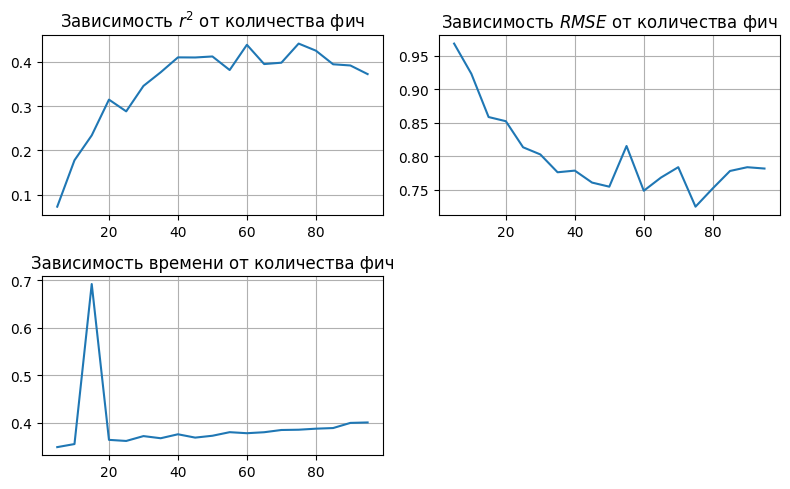

In [69]:
plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
plt.plot(results['features_number'], results['R2'])
plt.title("Зависимость $r^2$ от количества фич")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(results['features_number'], results['RMSE'])
plt.title("Зависимость $RMSE$ от количества фич")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(results['features_number'], results['time'])
plt.title("Зависимость времени от количества фич")
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
results = []
for i in range(10,100,5):

    start = time()

    X = df.drop([feature], axis=1).values
    Y = df[feature].values

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    model = build_rbf_model(n_centers=i, **cfg_best_model)
    
    if cfg_best_model['output_learning'] == 'pseudoinverse':
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
    else:
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

    end = time()

    results.append({
        'centers_number': i,
        'RMSE': rmse,
        'R2': r2,
        'time': end - start
    })

results = pd.DataFrame(results)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


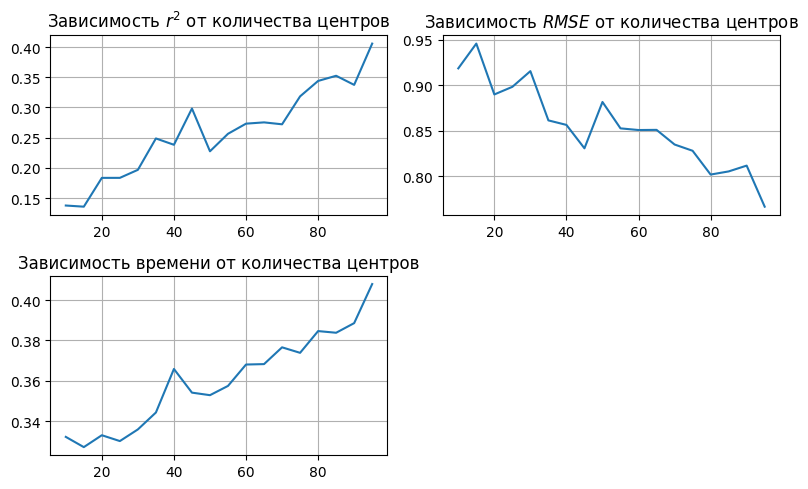

In [71]:
plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
plt.plot(results['centers_number'], results['R2'])
plt.title("Зависимость $r^2$ от количества центров")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(results['centers_number'], results['RMSE'])
plt.title("Зависимость $RMSE$ от количества центров")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(results['centers_number'], results['time'])
plt.title("Зависимость времени от количества центров")
plt.grid(True)

plt.tight_layout()
plt.show()

Из графиков видно, что проклятья размерности не наблюдается, ну а производительность (по времени) очевидно ухудшается с увеличением числа фич

## 4) "я настолько оптимизировал своё время, что не хоэу на пары по оптимизации" или веселая история оптимизации рбфсети

гибридный франкенштейн

In [72]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split



def create_hybrid_model(X_train, num_centers=50, kernel_type='gaussian', 
                       init_method='kmeans', sigma_method='nearest',
                       mlp_layers=[64, 32], activation='relu', 
                       l2_reg=0.001):
    

    centers = initialize_centers(init_method, X_train, num_centers)
    sigmas = calculate_sigmas(sigma_method, centers, X_train)
    
    inputs = Input(shape=(X_train.shape[1],))
    
    # RBF слой
    rbf_layer = RBFLayer(
        num_centers=num_centers,
        kernel_type=kernel_type,
        initial_centers=centers,
        initial_sigmas=sigmas,
        trainable_centers=(init_method == 'random')
    )(inputs)
    
    direct_features = Dense(X_train.shape[1], activation='linear')(inputs)

    x = Concatenate()([rbf_layer, direct_features])

    # MLP часть
    for units in mlp_layers:
        x = Dense(units, activation=activation, 
                 kernel_regularizer=l2(l2_reg))(x)
    
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp,test_size=0.5)

hybrid_model = create_hybrid_model(
    x_train,
    num_centers=30,
    kernel_type='gaussian',
    init_method='kmeans',
    sigma_method='nearest',
    mlp_layers=[128, 64, 32],
    activation='swish',
    l2_reg=0.01
)

hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

history = hybrid_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=64,
    verbose=1
)

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2599 - mae: 0.7600 - val_loss: 2.5449 - val_mae: 0.6757
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3870 - mae: 0.6617 - val_loss: 1.9760 - val_mae: 0.6422
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8308 - mae: 0.6078 - val_loss: 1.5893 - val_mae: 0.6213
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4745 - mae: 0.5843 - val_loss: 1.3345 - val_mae: 0.6062
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2119 - mae: 0.5645 - val_loss: 1.1525 - val_mae: 0.5948
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0396 - mae: 0.5429 - val_loss: 1.0224 - val_mae: 0.5828
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8906 - mae: 0.5180 - val_loss: 0.9152 - val_mae: 0.5711
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7901 - mae: 0.5037 - val_loss: 0.8400 - val_mae: 0.5427
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.702

In [73]:
rmse = root_mean_squared_error(hybrid_model.predict(x_test), y_test)
r2 = r2_score(hybrid_model.predict(x_test), y_test)
print(f'RMSE: {rmse:.4f}, R2: {r2}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 0.6347, R2: 0.5695864571255667


 кучакода

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dense
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time


# приняд морально волевое скопировать кусок кода и не плавить себе мозг
class RBFLayer(Layer):
    def __init__(self, num_centers, kernel_type='gaussian', **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.num_centers = num_centers
        self.kernel_type = kernel_type
        
    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.num_centers, input_shape[-1]),
            initializer='random_normal',
            trainable=True
        )
        
        self.sigmas = self.add_weight(
            name='sigmas',
            shape=(self.num_centers,),
            initializer='ones',
            trainable=True
        )
        
    def call(self, inputs):
        pairwise_diff = tf.expand_dims(inputs, 1) - tf.expand_dims(self.centers, 0)
        pairwise_sqdist = tf.reduce_sum(tf.square(pairwise_diff), axis=-1)
        
        if self.kernel_type == 'gaussian':
            return tf.exp(-pairwise_sqdist / (2 * tf.square(self.sigmas) + 1e-6))
        elif self.kernel_type == 'multiquadric':
            return tf.sqrt(1 + pairwise_sqdist / tf.square(self.sigmas))
        elif self.kernel_type == 'inverse_multiquadric':
            return 1/(tf.sqrt(1 + pairwise_sqdist / tf.square(self.sigmas)) + 1e-6)
        else:
            raise ValueError("Unsupported kernel type")
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_centers)

class MiniBatchRBFLayer(RBFLayer):
    def __init__(self, num_centers, kernel_type='gaussian', **kwargs):
        super(MiniBatchRBFLayer, self).__init__(num_centers, kernel_type, **kwargs)
        
    def build(self, input_shape):
        kmeans = MiniBatchKMeans(n_clusters=self.num_centers, 
                               random_state=42,
                               batch_size=1024)
        kmeans.fit(self.X_train)
        initial_centers = kmeans.cluster_centers_
        
        nbrs = NearestNeighbors(n_neighbors=2).fit(initial_centers)
        distances, _ = nbrs.kneighbors(initial_centers)
        initial_sigmas = distances[:, 1] / np.sqrt(2)
        
        self.centers = self.add_weight(
            name='centers',
            shape=(self.num_centers, input_shape[-1]),
            initializer=tf.constant_initializer(initial_centers),
            trainable=False
        )
        
        self.sigmas = self.add_weight(
            name='sigmas',
            shape=(self.num_centers,),
            initializer=tf.constant_initializer(initial_sigmas),
            trainable=True
        )

class KDRBFLayer(RBFLayer):
    def __init__(self, num_centers, kernel_type='gaussian', **kwargs):
        super(KDRBFLayer, self).__init__(num_centers, kernel_type, **kwargs)
        
    def build(self, input_shape):
        kmeans = KMeans(n_clusters=self.num_centers, random_state=42)
        kmeans.fit(self.X_train)
        initial_centers = kmeans.cluster_centers_
        
        nbrs = NearestNeighbors(n_neighbors=2).fit(initial_centers)
        distances, _ = nbrs.kneighbors(initial_centers)
        initial_sigmas = distances[:, 1] / np.sqrt(2)
        
        self.centers = self.add_weight(
            name='centers',
            shape=(self.num_centers, input_shape[-1]),
            initializer=tf.constant_initializer(initial_centers),
            trainable=False
        )
        
        self.sigmas = self.add_weight(
            name='sigmas',
            shape=(self.num_centers,),
            initializer=tf.constant_initializer(initial_sigmas),
            trainable=True
        )
    
    def call(self, inputs):
        diff = tf.expand_dims(inputs, 1) - tf.expand_dims(self.centers, 0)
        squared_dist = tf.reduce_sum(tf.square(diff), axis=-1)
        
        _, indices = tf.math.top_k(-squared_dist, k=min(5, self.num_centers))

        batch_size = tf.shape(inputs)[0]
        rows = tf.repeat(tf.range(batch_size), min(5, self.num_centers))
        cols = tf.reshape(indices, [-1])
        updates = tf.ones(tf.shape(rows)[0])
        mask = tf.scatter_nd(
            tf.stack([rows, cols], axis=1),
            updates,
            [batch_size, self.num_centers]
        )

        rbf = tf.exp(-squared_dist / (2 * tf.square(self.sigmas)))
        return rbf * mask

def train_pseudo_inverse(model, X, y):
    rbf_layer = model.layers[0]
    rbf_model = Sequential([rbf_layer])
    rbf_features = rbf_model.predict(X, verbose=0)
    
    y = y.reshape(-1, 1)
    weights = np.linalg.pinv(rbf_features) @ y
    
    if len(model.layers) > 1:
        output_layer = model.layers[1]
        output_layer.build((None, rbf_layer.num_centers))
        output_layer.set_weights([weights, np.zeros(1)])
    
    return model

def train_pseudo_inverse_fast(model, X, y, n_components=None, n_oversamples=10):
    rbf_layer = model.layers[0]
    rbf_model = Sequential([rbf_layer])
    rbf_features = rbf_model.predict(X, verbose=0)
    
    if n_components is None:
        n_components = min(rbf_features.shape[1]//2, 100)
        n_components = max(n_components, 1) 

    U, s, Vh = randomized_svd(
        rbf_features,
        n_components=n_components,
        n_oversamples=n_oversamples,
        random_state=42
    )
        
    s_inv = np.zeros_like(s)
    s_inv[s > 1e-10] = 1/s[s > 1e-10]
    W = Vh.T @ np.diag(s_inv) @ U.T @ y.reshape(-1, 1)
    
    if len(model.layers) > 1:
        output_layer = model.layers[1]
        output_layer.build((None, rbf_layer.num_centers))
        output_layer.set_weights([W, np.array([0.0])])
        
    return model

def evaluate_method(method_func, method_name, x_train, y_train, x_val, y_val):
    start_time = time.time()
    model = method_func(x_train, y_train)
    train_time = time.time() - start_time
    
    y_pred = model.predict(x_val, verbose=0)
    rmse = root_mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    return {'Метод': method_name, 'Время': train_time, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def baseline_train(X, y):
    model = Sequential([RBFLayer(50), Dense(1)])
    return train_pseudo_inverse(model, X, y)

def minibatch_kmean_train(X, y):
    MiniBatchRBFLayer.X_train = X
    model = Sequential([MiniBatchRBFLayer(50), Dense(1)])
    return train_pseudo_inverse(model, X, y)

def kdtree_train(X, y):
    KDRBFLayer.X_train = X
    model = Sequential([KDRBFLayer(50), Dense(1)])
    return train_pseudo_inverse(model, X, y)

def sdv_train(X, y):
    model = Sequential([RBFLayer(50), Dense(1)])
    return train_pseudo_inverse_fast(model, X, y)

    
methods = [
    (baseline_train, "Базовая RBF"),
    (minibatch_kmean_train, "MiniBatch KMean"),
    (kdtree_train, "KD-Tree"),
    (sdv_train, "SDV ускорение"),
]

results = []
for func, name in methods:
    print(f"{name} в процессе")
    results.append(evaluate_method(func, name, x_train, y_train, x_val, y_val))

results_df = pd.DataFrame(results)
print(results_df)

Базовая RBF в процессе
MiniBatch KMean в процессе
KD-Tree в процессе
SDV ускорение в процессе
             Метод     Время      RMSE       MAE         R2
0      Базовая RBF  0.229368  5.595617  1.092390 -31.745485
1  MiniBatch KMean  0.306376  0.880771  0.723336   0.188700
2          KD-Tree  0.311695  0.905821  0.750987   0.141895
3    SDV ускорение  0.215374  0.991386  0.841399  -0.027877


оно работаетпотпапвпоавтпаыи

## 5) Сравнение с другими моделями

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Support Vector Regression": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor()
}

results = {}

for name, model in models.items():

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {
        'model': model,
        'mse': mse,
        'mae': mae,
        'r2': r2
    }



print("{:<25} {:<10} {:<10} {:<10}".format('Model', 'MSE', 'MAE', 'R2'))
print("-" * 55)
for name, result in results.items():
    print("{:<25} {:<10.4f} {:<10.4f} {:<10.4f}".format(
        name, result['mse'], result['mae'], result['r2']))


Model                     MSE        MAE        R2        
-------------------------------------------------------
Linear Regression         0.6524     0.6648     0.3019    
Ridge Regression          0.6525     0.6649     0.3018    
Support Vector Regression 0.3947     0.4681     0.5777    
Random Forest             0.2625     0.3867     0.7191    
XGBoost                   0.2681     0.3837     0.7131    


## 6) Ну кажись выводы

Ну что я могу сказать, в плане реализации это что-то с чем-то

Касаемо более состоятельных выводов по пунктам

1) Данные мягко говоря для обучения плохо подходят. Они скорее созданы для некой сводной статистики, т.к. куча метрик вычисленно постфактум. Кроме того, много признаков имеют низкую зависимость от целевой переменной, которую выбрать тоже было не самой тривиальной задачкой. Я выбрал прогноз мирового ранга тимы, т.к. не нашел в датасете столбцов, позволяющих вычислить эту характеристику детерминированным алгоритмом (ну типа формула какая-то)

2) Танцы с бубном в виде перебора рбф-функций и прочих характеристик дали относительно неплохой наверное результат, на пике было в районе 0.4 на лучшей комбинации. по датафрейму results_df в этой части лабы в целом видно, насколько сильно выбор тех или иных параметров влияет на точность. Однако меня позабавило что не редко лучшей рбф является инвертированная мультиквадратичная, я ожидал что она будет менее стабильной

3) Самый лайтовый имхо пункт. Выводы в общем и целом я сделал еще там, продублирую лишь то, что проклятья размерности в моём случае не наблюдается, поскольку ошибка уменьшается, точность наоборот апается. Касаемо времязатратности обучения могу вкинуть что оно очевидно растет с увеличением количества центров и фич

4) Здесь некоторые пункты пришлось опустить, иначе я бы не уложился в дедлайн. Касаемо точности: франкенштейн рбфки и млп выдал результат лучше, чем в пункте 2, остальные модификации хоть и по скорости довольно неплохи, но точность у них отвратительная

5) SVR выдал результат сопоставимый с франкенштейном, однако базовый рандомфорест и хгбуст разнесли все сотни строк кода, что я так долго пытался заставить работать. Даже в некотором роде обидно


Общее заключение

Гибрид рбф и млп показал себя лучше всех других танцев с бубном связанных с рбфкой. Относительно хгбуста у него есть плюс в скорости, однако в точности он пожалуй сильно уступает. Возможно выьор более удачной архитектуры мог бы дать более хороший результат, возможно даже сопоставимый с хгбустом, но одно я могу сказать точно: оно того вообще не стоит. Классические модельки регрессии более чем хорошо работают на этом датасете.

ну как-то так